# Loads (Notice git integration)

In [1]:
!pip install pyro-ppl

     |████████████████████████████████| 522kB 2.8MB/s 


In [0]:
import matplotlib

In [0]:
# "Standard" imports
import numpy as np
from time import time
import itertools
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd

# Pytorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.distributions import TransformedDistribution

# Pyro imports
import pyro
from pyro.distributions import ConditionalTransformedDistribution, ConditionalTransformModule, TransformModule
import pyro.distributions as dist
from pyro.distributions.transforms import affine_coupling, affine_autoregressive, permute

# Sklearn imports
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# Notebooks imports
from IPython.display import Image, display, clear_output
from tqdm import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual





In [0]:
%matplotlib inline

In [5]:
from google.colab import drive
import sys
import os
drive.mount('/content/drive/')
root_path = 'drive/My Drive/Colab_Notebooks/normalizingflows'
trained_flows_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/trained_flows'
dataset_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/datasets'
sys.path.append(root_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [8]:
%cd drive/'My Drive'/Thesis/code/DEwNF/
!git pull
%cd /content/

/content/drive/My Drive/Thesis/code/DEwNF
Already up to date.
/content


In [0]:
git_folder_path = 'drive/My Drive/Thesis/code/DEwNF/'
sys.path.append(git_folder_path)

In [0]:
#from DEwNF.flows import ConditionalAffineCoupling, ConditionedAffineCoupling, ConditionalNormalizingFlowWrapper, conditional_affine_coupling
from DEwNF.utils import plot_4_contexts_cond_flow, plot_loss, sliding_plot_loss, plot_samples, split_synthetic
from DEwNF.samplers import RotatingTwoMoonsConditionalSampler

# Extended RotatingTwoMoons

### Two Moons

In [0]:
n_samples = 10000

In [0]:
cond_two_moons = RotatingTwoMoonsConditionalSampler(noise=0.05)
x, y = cond_two_moons.conditioned_sample(n_samples=n_samples)

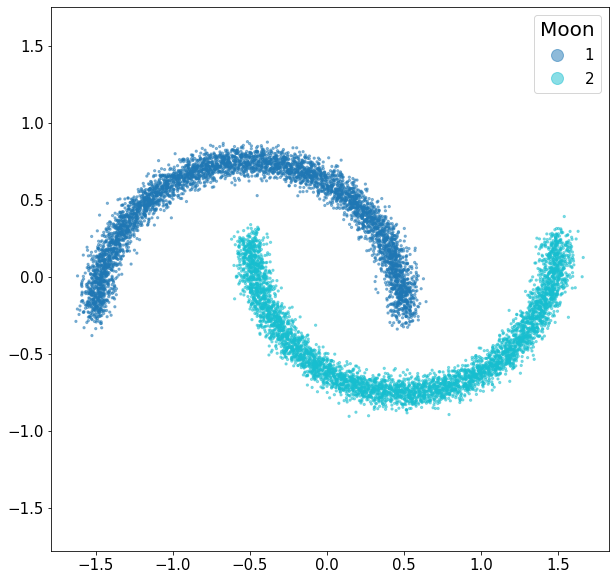

In [14]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,10))
scatter = plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5, c=np.array(y) + 1, cmap='tab10', label=y)
plt.legend(*scatter.legend_elements(), title='Moon', fontsize=15, title_fontsize=20, markerscale=2)
plt.axis('equal');

### Rotating Two Moons

In [0]:
plt.rcParams['image.cmap'] = 'tab10'

In [0]:
# joint rotating sample
cond_two_moons = RotatingTwoMoonsConditionalSampler(noise=0.05)
x, y ,theta = cond_two_moons.joint_sample(n_samples)

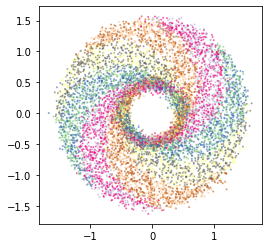

In [0]:
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], c=theta.squeeze(), cmap='Accent', s=1, alpha=0.5)
plt.axis('equal');

In [0]:
x_0, y_0 = cond_two_moons.conditioned_sample(n_samples = 2000, theta=torch.tensor([0]))
x_1, y_1 = cond_two_moons.conditioned_sample(n_samples = 2000, theta=torch.tensor([np.pi/4]))
x_2, y_2 = cond_two_moons.conditioned_sample(n_samples = 2000, theta=torch.tensor([np.pi/2]))
x_3, y_3 = cond_two_moons.conditioned_sample(n_samples = 2000, theta=torch.tensor([3*np.pi/4]))

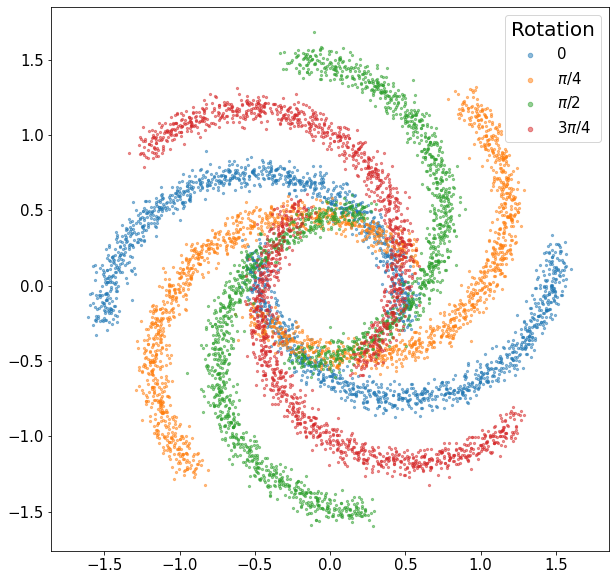

In [17]:
plt.figure(figsize=(10,10))
plt.set_cmap('tab10')
plt.scatter(x_0[:,0], x_0[:,1], s=5, alpha=0.5)
plt.scatter(x_1[:,0], x_1[:,1], s=5, alpha=0.5)
plt.scatter(x_2[:,0], x_2[:,1], s=5, alpha=0.5)
plt.scatter(x_3[:,0], x_3[:,1], s=5, alpha=0.5)
plt.legend(['0', '$\pi$/4', '$\pi$/2', '3$\pi$/4'], title='Rotation', fontsize=15, title_fontsize=20, markerscale=2)
plt.axis('equal');

### Rotating Translating Two Moons

In [0]:
# joint rotating and translating sample
cond_two_moons = RotatingTwoMoonsConditionalSampler(noise=0.05)
x, y ,theta, trans = cond_two_moons.joint_translation_sample(n_samples)

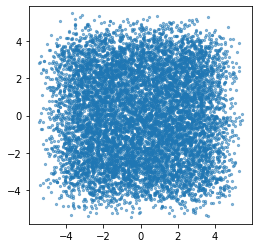

In [0]:
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');

In [0]:
t1 = torch.tensor([0,0])
t1x_0, t1y_0,_ ,_ = cond_two_moons.conditioned_translated_sample(n_samples = 2000, theta=torch.tensor([0]), trans=t1)
t1x_1, t1y_1,_ ,_ = cond_two_moons.conditioned_translated_sample(n_samples = 2000, theta=torch.tensor([np.pi/4]),trans=t1)
t1x_2, t1y_2,_ ,_ = cond_two_moons.conditioned_translated_sample(n_samples = 2000, theta=torch.tensor([np.pi/2]),trans=t1)
t1x_3, t1y_3,_ ,_ = cond_two_moons.conditioned_translated_sample(n_samples = 2000, theta=torch.tensor([3*np.pi/4]),trans=t1)

In [0]:
t2 = torch.tensor([4,4])
t2x_0, t2y_0,_ ,_ = cond_two_moons.conditioned_translated_sample(n_samples = 2000, theta=torch.tensor([0]), trans=t2)
t2x_1, t2y_1,_ ,_ = cond_two_moons.conditioned_translated_sample(n_samples = 2000, theta=torch.tensor([np.pi/4]),trans=t2)
t2x_2, t2y_2,_ ,_ = cond_two_moons.conditioned_translated_sample(n_samples = 2000, theta=torch.tensor([np.pi/2]),trans=t2)
t2x_3, t2y_3,_ ,_ = cond_two_moons.conditioned_translated_sample(n_samples = 2000, theta=torch.tensor([3*np.pi/4]),trans=t2)

In [0]:
t3 = torch.tensor([-4,-4])
t3x_0, t3y_0,_ ,_ = cond_two_moons.conditioned_translated_sample(n_samples = 2000, theta=torch.tensor([0]), trans=t3)
t3x_1, t3y_1,_ ,_ = cond_two_moons.conditioned_translated_sample(n_samples = 2000, theta=torch.tensor([np.pi/4]),trans=t3)
t3x_2, t3y_2,_ ,_ = cond_two_moons.conditioned_translated_sample(n_samples = 2000, theta=torch.tensor([np.pi/2]),trans=t3)
t3x_3, t3y_3,_ ,_ = cond_two_moons.conditioned_translated_sample(n_samples = 2000, theta=torch.tensor([3*np.pi/4]),trans=t3)

In [0]:
t4 = torch.tensor([4,-4])
t4x_0, t4y_0,_ ,_ = cond_two_moons.conditioned_translated_sample(n_samples = 2000, theta=torch.tensor([0]), trans=t4)
t4x_1, t4y_1,_ ,_ = cond_two_moons.conditioned_translated_sample(n_samples = 2000, theta=torch.tensor([np.pi/4]),trans=t4)
t4x_2, t4y_2,_ ,_ = cond_two_moons.conditioned_translated_sample(n_samples = 2000, theta=torch.tensor([np.pi/2]),trans=t4)
t4x_3, t4y_3,_ ,_ = cond_two_moons.conditioned_translated_sample(n_samples = 2000, theta=torch.tensor([3*np.pi/4]),trans=t4)

In [0]:
t5 = torch.tensor([-4,4])
t5x_0, t5y_0,_ ,_ = cond_two_moons.conditioned_translated_sample(n_samples = 2000, theta=torch.tensor([0]), trans=t5)
t5x_1, t5y_1,_ ,_ = cond_two_moons.conditioned_translated_sample(n_samples = 2000, theta=torch.tensor([np.pi/4]),trans=t5)
t5x_2, t5y_2,_ ,_ = cond_two_moons.conditioned_translated_sample(n_samples = 2000, theta=torch.tensor([np.pi/2]),trans=t5)
t5x_3, t5y_3,_ ,_ = cond_two_moons.conditioned_translated_sample(n_samples = 2000, theta=torch.tensor([3*np.pi/4]),trans=t5)

In [0]:
import matplotlib.cm as cm

In [25]:
np.linspace(0,1,20)

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

In [0]:
colors = cm.tab20(np.linspace(0, 1, 20))

In [27]:
colors

array([[0.12156863, 0.46666667, 0.70588235, 1.        ],
       [0.68235294, 0.78039216, 0.90980392, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ],
       [1.        , 0.73333333, 0.47058824, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [0.59607843, 0.8745098 , 0.54117647, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ],
       [1.        , 0.59607843, 0.58823529, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.77254902, 0.69019608, 0.83529412, 1.        ],
       [0.54901961, 0.3372549 , 0.29411765, 1.        ],
       [0.76862745, 0.61176471, 0.58039216, 1.        ],
       [0.89019608, 0.46666667, 0.76078431, 1.        ],
       [0.96862745, 0.71372549, 0.82352941, 1.        ],
       [0.49803922, 0.49803922, 0.49803922, 1.        ],
       [0.78039216, 0.78039216, 0.78039216, 1.        ],
       [0.7372549 , 0.74117647, 0.13333333, 1.        ],
       [0.85882353, 0.85882353,

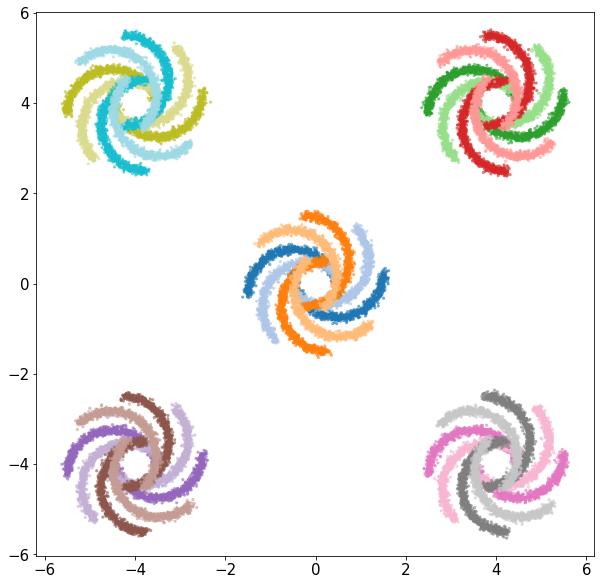

In [28]:
plt.figure(figsize=(10,10))
plt.set_cmap('tab20c')
plt.scatter(t1x_0[:,0], t1x_0[:,1], s=5, alpha=0.5, c = [colors[0] for _ in range(2000)])
plt.scatter(t1x_1[:,0], t1x_1[:,1], s=5, alpha=0.5, c = [colors[1] for _ in range(2000)])
plt.scatter(t1x_2[:,0], t1x_2[:,1], s=5, alpha=0.5, c = [colors[2] for _ in range(2000)])
plt.scatter(t1x_3[:,0], t1x_3[:,1], s=5, alpha=0.5, c = [colors[3] for _ in range(2000)])

plt.scatter(t2x_0[:,0], t2x_0[:,1], s=5, alpha=0.5, c = [colors[4] for _ in range(2000)])
plt.scatter(t2x_1[:,0], t2x_1[:,1], s=5, alpha=0.5, c = [colors[5] for _ in range(2000)])
plt.scatter(t2x_2[:,0], t2x_2[:,1], s=5, alpha=0.5, c = [colors[6] for _ in range(2000)])
plt.scatter(t2x_3[:,0], t2x_3[:,1], s=5, alpha=0.5, c = [colors[7] for _ in range(2000)])

plt.scatter(t3x_0[:,0], t3x_0[:,1], s=5, alpha=0.5, c = [colors[8] for _ in range(2000)])
plt.scatter(t3x_1[:,0], t3x_1[:,1], s=5, alpha=0.5, c = [colors[9] for _ in range(2000)])
plt.scatter(t3x_2[:,0], t3x_2[:,1], s=5, alpha=0.5, c = [colors[10] for _ in range(2000)])
plt.scatter(t3x_3[:,0], t3x_3[:,1], s=5, alpha=0.5, c = [colors[11] for _ in range(2000)])

plt.scatter(t4x_0[:,0], t4x_0[:,1], s=5, alpha=0.5, c = [colors[12] for _ in range(2000)])
plt.scatter(t4x_1[:,0], t4x_1[:,1], s=5, alpha=0.5, c = [colors[13] for _ in range(2000)])
plt.scatter(t4x_2[:,0], t4x_2[:,1], s=5, alpha=0.5, c = [colors[14] for _ in range(2000)])
plt.scatter(t4x_3[:,0], t4x_3[:,1], s=5, alpha=0.5, c = [colors[15] for _ in range(2000)])

plt.scatter(t5x_0[:,0], t5x_0[:,1], s=5, alpha=0.5, c = [colors[16] for _ in range(2000)])
plt.scatter(t5x_1[:,0], t5x_1[:,1], s=5, alpha=0.5, c = [colors[17] for _ in range(2000)])
plt.scatter(t5x_2[:,0], t5x_2[:,1], s=5, alpha=0.5, c = [colors[18] for _ in range(2000)])
plt.scatter(t5x_3[:,0], t5x_3[:,1], s=5, alpha=0.5, c = [colors[19] for _ in range(2000)])
plt.axis('equal');

# Fitted models to extended versions

### Rotating w. Class

In [0]:
file_path = f'{root_path}/plot_notebooks/models_for_plots/model_for_plot.pickle'
with open(file_path, 'rb') as f:
    loaded_dict = pickle.load(f)

In [0]:
loaded_flow = loaded_dict['model']


In [32]:
loaded_dict['settings']

{'batch_size': 1000,
 'batchnorm_momentum': None,
 'c_net_depth': 4,
 'c_net_h_dim': 18,
 'clipped_adam': 10.0,
 'context_dropout': None,
 'context_n_depth': 4,
 'context_n_h_dim': 16,
 'coupling_dropout': None,
 'data_size': 40000,
 'epochs': 3000,
 'flow_depth': 4,
 'l2_reg': None,
 'lr': 0.0001,
 'problem_dim': 2,
 'rich_context_dim': 5}

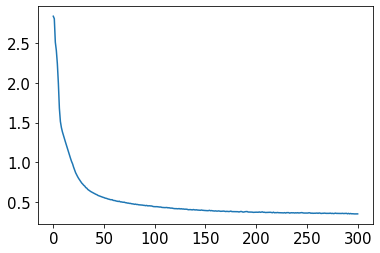

In [33]:
plt.plot(loaded_dict['logs']['train'])

In [0]:
two_moons_folder = os.path.join(dataset_folder, 'two_moons')
csv_path = os.path.join(two_moons_folder, 'rotating_two_moons_100k_n005.csv')
data_df = pd.read_csv(csv_path)

batch_size = 500
data_size = 10000
cuda_exp = True

In [0]:
# Load data
train_dataloader, test_dataloader, obs_scaler, context_scaler = split_synthetic(data_df, batch_size,
                                                                                data_size, cuda_exp, random_state=42)

In [0]:
def create_overlay(shape, bounds, flow_dist, obs_scaler):
    cm = matplotlib.cm.get_cmap('cividis')
    
    nlats, nlons = shape
    
    lats_array = torch.linspace(start=bounds[1][0], end=bounds[0][0], steps=nlats).float()
    lons_array = torch.linspace(start=bounds[0][1], end=bounds[1][1], steps=nlons).float()
    x, y = torch.meshgrid(lats_array, lons_array)

    points = torch.stack((x.reshape(-1), y.reshape(-1)), axis=1).cuda()
    scaled_points = torch.tensor(obs_scaler.transform(points.cpu())).float().cuda()
    with torch.no_grad():
        data = flow_dist.log_prob(scaled_points).reshape(nlats,nlons).cpu().detach().numpy()
    
    data = np.exp(data).T # this transpose should not be necesary
    data = (data - data.min()) / (data.max() - data.min())

    overlay = cm(data)
    return lons_array, lats_array, overlay, data

In [47]:
## interactive plot

def model_tester3(theta, moon, flow, obs_scaler, context_scaler):
    theta = torch.tensor([theta])
    moon = torch.tensor([moon])
    context = torch.cat((moon, theta)).unsqueeze(0)
    scaled_context = torch.tensor(context_scaler.transform(context))
    scaled_context = scaled_context.float().cuda()
    cond_dist = flow.condition(scaled_context)
    x, point_moon = cond_two_moons.conditioned_sample(n_samples=512, theta=theta)
    bounds = [[-3,-2], [3,2]]
    _,_, _, data = create_overlay(shape = (800,800), bounds=bounds, flow_dist = cond_dist, obs_scaler=obs_scaler)  
    x_s = cond_dist.sample((512,))
    if x_s.is_cuda:
        x_s = x_s.cpu()
    scaled_xs = obs_scaler.inverse_transform(x_s)
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5, c=np.array(point_moon) + 1, cmap='winter', label=point_moon)

    #plt.scatter(scaled_xs[:, 0], scaled_xs[:, 1], c='b', s=1)
    plt.xlim(bounds[0][0],bounds[1][0])
    plt.ylim(bounds[0][1],bounds[1][1])
    test = plt.imshow(data, cmap='cividis', extent=(bounds[1][0],bounds[0][0], bounds[1][1], bounds[0][1]), label="Target distribution")
    plt.legend(*scatter.legend_elements(), title='Moon', fontsize=15, title_fontsize=20, markerscale=2, framealpha=0.3)
    plt.colorbar(test, shrink=0.6)
    plt.show()



interactive_plot = interactive(model_tester3,
                               theta=(0.,2*np.pi),
                               moon=(0.,1.,1),
                               flow=fixed(loaded_flow),
                               obs_scaler=fixed(obs_scaler),
                               context_scaler=fixed(context_scaler))
interactive_plot




interactive(children=(FloatSlider(value=3.141592653589793, description='theta', max=6.283185307179586), FloatS…

In [0]:
def create_plot(axs, x, point_moon, dist, trans_idx, trans_type, obs_scaler):
    bounds = [[-3,-2], [3,2]]
    _, _, _, data = create_overlay(shape = (200,200), bounds=bounds, flow_dist = dist, obs_scaler=obs_scaler)  
    x_s = dist.sample((512,))
    if x_s.is_cuda:
        x_s = x_s.cpu()
    scatter = axs.scatter(x[:,0], x[:,1], s=5, alpha=0.5, c=np.array(point_moon) + 1, cmap='winter', label=point_moon)
    #axs.scatter(x_s[:, 0], x_s[:, 1], c='b', s=1, alpha=0.1)
    axs.set_xlim(-3,3)
    axs.set_ylim(-2,2)
    axs.set_title(f'After transformation number {trans_idx} \n({trans_type})', fontsize=20)
    axs.legend(*scatter.legend_elements(), title='Moon', fontsize=15, title_fontsize=15, markerscale=2, framealpha=0.3)
    
    colors = axs.imshow(data, cmap='cividis', extent=(3,-3, 2, -2))
    return colors
    

In [43]:
def rename_trans(name):
    if name == "ConditionedAffineCoupling2()":
        return "Conditioned Affine Coupling"
    if name == "Permute()":
        return "Permute"
    if name == "BatchNorm()":
        return "Batchnorm"

def model_tester4(theta, moon, flow, obs_scaler, context_scaler):
    flow.modules.eval()
    theta = torch.tensor([theta])
    moon = torch.tensor([moon])
    context = torch.cat((moon, theta)).unsqueeze(0)
    scaled_context = torch.tensor(context_scaler.transform(context))
    scaled_context = scaled_context.float().cuda()
    cond_dist = flow.condition(scaled_context)
    x, point_moon = cond_two_moons.conditioned_sample(n_samples=512, theta=torch.tensor([theta]))
    bounds = [[-3,-2], [3,2]]
    n_trans = len(cond_dist.transforms)
    fig, axs = plt.subplots(((n_trans) // 2) +1 , 2,  figsize=(25,n_trans*5),gridspec_kw = {'wspace':0, 'hspace':0})

    colors = create_plot(axs[0, 0], x, point_moon, cond_dist.base_dist.to_event(1), 0, 'Base distribution', obs_scaler)
    plt.colorbar(colors, ax=axs[0,0], shrink=0.8)
    for i in range(0, n_trans):
        temp_dist = TransformedDistribution(cond_dist.base_dist, cond_dist.transforms[0:i+1])
        trans_type = rename_trans(cond_dist.transforms[i].__str__())
        colors = create_plot(axs[(i+1) // 2, (i+1) % 2 ], x, point_moon, temp_dist, i+1, trans_type, obs_scaler)
        plt.colorbar(colors, ax=axs[(i+1) // 2, (i+1) % 2 ],shrink=0.8)
    if n_trans % 2 == 0:
        fig.delaxes(axs[n_trans//2, 1])

interactive_plot = interactive(model_tester4,
                               theta=(0.,2*np.pi),
                               moon=(0.,1.,1),
                               flow=fixed(loaded_flow),
                               obs_scaler=fixed(obs_scaler),
                               context_scaler=fixed(context_scaler))
interactive_plot


interactive(children=(FloatSlider(value=3.141592653589793, description='theta', max=6.283185307179586), FloatS…